# 1次元の畳み込みニューラルネットワークスクラッチ

畳み込みニューラルネットワーク（CNN） のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


このSprintでは1次元の 畳み込み層 を作成し、畳み込みの基礎を理解することを目指します。次のSprintでは2次元畳み込み層とプーリング層を作成することで、一般的に画像に対して利用されるCNNを完成させます。


クラスの名前はScratch1dCNNClassifierとしてください。クラスの構造などは前のSprintで作成したScratchDeepNeuralNetrowkClassifierを参考にしてください。


1次元畳み込み層とは
CNNでは画像に対しての2次元畳み込み層が定番ですが、ここでは理解しやすくするためにまずは1次元畳み込み層を実装します。1次元畳み込みは実用上は自然言語や波形データなどの 系列データ で使われることが多いです。


畳み込みは任意の次元に対して考えることができ、立体データに対しての3次元畳み込みまではフレームワークで一般的に用意されています。


データセットの用意
検証には引き続きMNISTデータセットを使用します。1次元畳み込みでは全結合のニューラルネットワークと同様に平滑化されたものを入力します。


### 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成
チャンネル数を1に限定した1次元畳み込み層のクラスSimpleConv1dを作成してください。基本構造は前のSprintで作成した全結合層のFCクラスと同じになります。なお、重みの初期化に関するクラスは必要に応じて作り変えてください。Xavierの初期値などを使う点は全結合層と同様です。


ここでは パディング は考えず、ストライド も1に固定します。また、複数のデータを同時に処理することも考えなくて良く、バッチサイズは1のみに対応してください。この部分の拡張はアドバンス課題とします。


フォワードプロパゲーションの数式は以下のようになります。

$$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$

a
i
 : 出力される配列のi番目の値


F
 : フィルタのサイズ


x
(
i
+
s
)
 : 入力の配列の(i+s)番目の値


w
s
 : 重みの配列のs番目の値


b
 : バイアス項


全てスカラーです。


次に更新式です。ここがAdaGradなどに置き換えられる点は全結合層と同様です。


$$
w_s^{\prime} = w_s - \alpha \frac{\partial L}{\partial w_s} \\
b^{\prime} = b - \alpha \frac{\partial L}{\partial b}
$$

α
 : 学習率


∂
L
∂
w
s
 : 
w
s
 に関する損失 
L
 の勾配


∂
L
∂
b
 : 
b
 に関する損失 
L
 の勾配


勾配 
∂
L
∂
w
s
 や 
∂
L
∂
b
 を求めるためのバックプロパゲーションの数式が以下です。


$$
\frac{\partial L}{\partial w_s} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}x_{(i+s)}\\
\frac{\partial L}{\partial b} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}
$$

∂
L
∂
a
i
 : 勾配の配列のi番目の値


N
o
u
t
 : 出力のサイズ


前の層に流す誤差の数式は以下です。



$$
\frac{\partial L}{\partial x_j} = \sum_{s=0}^{F-1} \frac{\partial L}{\partial a_{(j-s)}}w_s
$$

∂
L
∂
x
j
 : 前の層に流す誤差の配列のj番目の値


ただし、 
j
−
s
<
0
 または 
j
−
s
>
N
o
u
t
−
1
 のとき 
∂
L
∂
a
(
j
−
s
)
=
0
 です。


全結合層との大きな違いは、重みが複数の特徴量に対して共有されていることです。この場合は共有されている分の誤差を全て足すことで勾配を求めます。計算グラフ上での分岐はバックプロパゲーションの際に誤差の足し算をすれば良いことになります。



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.
/Users/apple/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/apple/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/apple/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

In [3]:
X_train = X_train.reshape(-1 , 784)
X_test = X_test.reshape(-1 , 784)
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


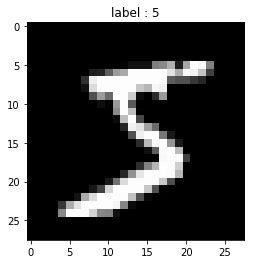

In [4]:
index = 0
image = X_train[index].reshape(28,28)
plt.imshow(image , "gray")
plt.title("label : {}".format(y_train[index]))
plt.show()

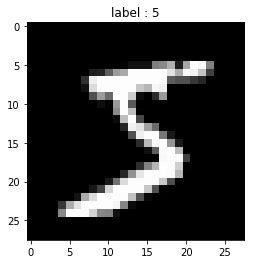

(28, 28)


In [5]:
index = 0
image = X_train[index].reshape(28,28)
image = image.astype(np.float)#float型に変換
image -= 105.35 #意図的に負の小数値を作り出してみる
plt.imshow(image , "gray")
plt.title("label : {}".format(y_train[index]))
plt.show()
print(image.shape)

In [6]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max())#1.0
print(X_train.min())#0.0

1.0
0.0


In [7]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [8]:
from sklearn.model_selection import train_test_split
X_train , X_val , y_train , y_val = train_test_split(
             X_train , y_train_one_hot , test_size = 0.20)
print(X_train.shape)
print(X_val.shape)

(48000, 784)
(12000, 784)


In [9]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [10]:
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)

for mini_X_train, mini_y_train in get_mini_batch:
    # このfor文内でミニバッチが使える
    pass

In [11]:
class XavierInitializer():
    def __init__(self, filter_num,filter_size):
        self.n_nodes1 = filter_num
        self.n_nodes2 = filter_size        
    
    def W(self):
        sigma = np.sqrt(1.0 / 1.0)
        self.W = sigma * np.random.randn(self.filter_num, self.filter_size)
        return self.W
    
    def B(self):
        sigma = np.sqrt(1.0 / 1.0)
        self.B = sigma * np.random.randn(self.filter_num)
        return self.B

In [12]:
class AdaGrad():
    def __init__(self , lr):
        self.lr = lr
        self.hw = None
        self.hb = None
    
    def update(self , layer):
#         layer.W = self.W
#         layer.B = self.B
#         layer.dW = self.dW
#         layer.dB = self.dB
        
        layer.hw += (layer.dW) * (layer.dW)
        layer.W -= self.lr * (layer.dW) / (np.sqrt(layer.hw) + 1e-7)
        layer.hb += (layer.dB) * (layer.dB)
        layer.B -= self.lr * (layer.dB) / (np.sqrt(layer.hb) + 1e-7)
        self.hw = layer.hw
        self.hb = layer.hb
        return layer.W, layer.B

In [13]:
class SimpleConv1d():
    def __init__(self,filter_num,filter_size,lr = 0.01,initializer=XavierInitializer,optimizer=AdaGrad(lr = 0.01),stride=1,pad=0,sigma=0.01):
        self.optimizer = optimizer
        self.initializer = initializer
        self.filter_num = filter_num
        self.filter_size = filter_size
        self.stride = stride
        self.sigma = sigma
        self.pad = pad
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
#         self.W = self.initializer.W(self. filter_num, self.filter_size)
#         self.B = self.initializer.B(self.filter_num)
        self.W = np.array([3, 5, 7]).astype(np.float)
        self.B = np.array([1]).astype(np.float)
        self.A_list = []
        self.N_out = None
        self.dW_list = []
        self.dB_list = []
        (self.filter_num+2*self.pad-self.filter_size)//self.stride + 1
        self.lr = lr
        self.hw = 0
        self.hb = 0
        
    def forward(self, X):
        self.X = X
        self.n_iter =   int(self.X.shape[0] - self.W.shape[0]/self.stride + 1)
        self.X_index = np.arange(self.W.shape[0])
        for i in range(self.n_iter):
            self.A = np.dot(self.X[self.X_index+i] , self.W) + self.B
            self.A_list = np.append(self.A_list,self.A)
        return self.A_list
    def backward(self , dA):
        self.X_index2 = np.arange(dA.shape[0])
        self.n_iter2 = int(self.X.shape[0] - dA.shape[0]//self.stride + 1)
        for i in range(dA.shape[0]):
            self.dW_list = []
            self.dB_list = []
            self.dB = np.sum(dA)
            self.dB_list.append(self.dB)
            for k in range(self.n_iter2):
                self.dW = np.dot(self.X[self.X_index2+k].T , dA)
                self.dW_list.append(self.dW)     
            for j in range(self.filter_size-1):
#                 if j-self.stride < 0 or j-self.stride > self.N_out-1:
                dZ=np.zeros(self.X.shape[0])
                for i in range(dA.shape[0]):
                    dZ[i:i+self.filter_size]+=self.W*dA[i]

        # 更新
        print(self.dB_list)
        print(self.dW_list)
        self = self.optimizer.update(self)
        return dZ
    
        def N_out(self):
            return  (self.filter_num[1]+2*self.pad-self.filter_size[2])//self.stride + 1

In [14]:
class SimpleInitializer():

    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, filter_num, filter_size):
        W = self.sigma * np.random.randn(filter_num , filter_size)
        
        return W
    def B(self, filter_size):
        B = self.sigma * np.random.randn(filter_size)
        
        return B

In [15]:
class XavierInitializer():
    def __init__(self, filter_num,filter_size):
        self.filter_num = filter_num
        self.filter_size = filter_size        
    
    def W(self):
        sigma = np.sqrt(1.0 / 1.0)
        self.W = sigma * np.random.randn(self.filter_num, self.filter_size)
        return self.W
    
    def B(self):
        sigma = np.sqrt(1.0 / 1.0)
        self.B = sigma * np.random.randn(self.filter_num)
        return self.B

In [16]:
class HeInitializer():
    def __init__(self,filter_num,filter_size):
        self.filter_num = filter_num
        self.filter_size = filter_size
    
    def W(self):
        sigma =  np.sqrt(2.0 / 1.0)
        self.W = sigma * np.random.randn(self.filter_num, self.filter_size)
        return self.W
    
    def B(self):
        sigma =  np.sqrt(2.0 / 1.0)
        self.W = sigma * np.random.randn(self.filter_num)
        return self.B

In [17]:
class SGD():
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return layer.W , layer.B

In [18]:
class SoftmaxWithLoss():
    def __init__(self):
        self.loss = None
        self.y = None
        
        
    def forward(self , x):
        if x.ndim == 2:
            x = x.T
            x = x - np.max(x, axis=0)
            y = np.exp(x) / np.sum(np.exp(x), axis=0)
            return y.T
        x = x - np.max(x)
        return np.exp(x) / np.sum(np.exp(x))
    
    def backward(self , z , y):
        self.dA = z - y
        return self.dA
    
    def Loss(self , z , y):
        loss =  -np.sum(y * np.log(z) + 1e-7) / y.shape[0]
        return loss

【問題2】1次元畳み込み後の出力サイズの計算  
畳み込みを行うと特徴量の数が変化します。どのように変化するかは以下の数式から求められます。パディングやストライドも含めています。この計算を行う関数を作成してください。


$$
N_{out} =  \frac{N_{in}+2P-F}{S} + 1\\
$$

N
o
u
t
 : 出力のサイズ（特徴量の数）


N
i
n
 : 入力のサイズ（特徴量の数）


P
 : ある方向へのパディングの数


F
 : フィルタのサイズ


S
 : ストライドのサイズ

In [19]:
stride = 1
pad = 0
filter_size = np.array([3, 5, 7]).shape[0]
filter_num = np.array([1,2,3,4]).shape[0]

def N_out(filter_num , padding , f_size , stride):
    N_out = (filter_num + 2*pad - filter_size)/stride + 1
    return N_out

In [20]:
N_out(filter_num , pad , filter_size , stride)

2.0

### 【問題3】小さな配列での1次元畳み込み層の実験
次に示す小さな配列でフォワードプロパゲーションとバックプロパゲーションが正しく行えているか確認してください。


入力x、重みw、バイアスbを次のようにします。

フォワードプロパゲーション
$$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$
a
i
  : 出力される配列のi番目の値


F
 : フィルタのサイズ


x
(
i
+
s
)
 : 入力の配列の(i+s)番目の値


w
s
 : 重みの配列のs番目の値


b
 : バイアス項

In [21]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])
dA = np.array([10, 20])
dA.shape

(2,)

In [22]:
s = SimpleConv1d(4,3)

In [23]:
s.forward(x)

array([35., 50.])

In [24]:
s.backward(dA)

[30]
[50, 80, 110]


array([ 30., 110., 170., 140.])

In [25]:
delta_x = np.array([30, 110, 170, 140])

In [27]:
N_out = 2
z_list = []
dA = np.array([10, 20])
X = np.array([1,2,3,4])
W = np.array([3, 5, 7])
for j in range(X.shape[0]):
    for s in range(W.shape[0]):
        if stride < 0 or j-stride > N_out-1:
            z = np.dot(dA , W.T)#zを０にする
            z_list.append(z)
        else:
            z = np.dot(dA , W.T)
            z_list.append(z)

ValueError: shapes (2,) and (3,) not aligned: 2 (dim 0) != 3 (dim 0)

In [28]:
# delta_x = np.array([30, 110, 170, 140])の導出
delta_x = np.array([])
for j in range(x.shape[0]):
    x_element = 0
    for s in range(w.shape[0]):        
        if j-s < 0 or j-s > dA.shape[0]-1:
            x_element += 0
        else:
            x_element += dA[j-s]*w[s]
    delta_x = np.append(delta_x, x_element)
print('delta_x:',delta_x)

delta_x: [ 30. 110. 170. 140.]


### 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成
チャンネル数を1に限定しない1次元畳み込み層のクラスConv1dを作成してください。


例えば以下のようなx, w, bがあった場合は、  
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)  
で、（入力チャンネル数、特徴量数）である。  
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)  
である。  
b = np.array([1, 2, 3]) # （出力チャンネル数）

In [29]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)(入力チャンネル数、特徴量数)
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)
b = np.array([1, 2, 3]) # （出力チャンネル数）
dA = np.array([[9,11],[32,35],[52,56]])

In [30]:
X_index = np.arange(W.shape[0])
X = np.array([[1, 2, 3, 4], [2, 3, 4, 5]])
W = np.ones((3, 2, 3)) 
B = np.array([1, 2, 3])
A_list = []
B_list = []
for k in range(W.shape[0]):
    A_list = []
    for j in range(X.shape[0]):
        A = 0
        for i in range(int(X.shape[1] - W.shape[0]/stride + 1)):
            A += np.dot(X[j][X_index+i] , W[k][j])
        A_list.append(A)
    B_list.append(A_list+B[k])
B_list = np.array(B_list)
print(B_list)

[[16. 22.]
 [17. 23.]
 [18. 24.]]


In [31]:
class XavierInitializer_2():
    def __init__(self, filter_num,filter_c,filter_size):
        self.filter_num = filter_num
        self.filter_size = filter_size        
    
    def W(self):
        sigma = np.sqrt(1.0 / 1.0)
        self.W = sigma * np.random.randn(self.filter_num,filter_c, self.filter_size)
        return self.W
    
    def B(self):
        sigma = np.sqrt(1.0 / 1.0)
        self.B = sigma * np.random.randn(self.filter_num)
        return self.B

In [32]:
class Conv1d():
    def __init__(self,filter_num,filter_size,lr = 0.01,initializer=XavierInitializer_2,optimizer=AdaGrad(lr = 0.01),stride=1,pad=0,sigma=0.01):
        self.optimizer = optimizer
        self.initializer = initializer
        self.stride = stride
        self.sigma = sigma
        self.pad = pad
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
#         self.W = self.initializer.W(self. filter_num, self.filter_size)
#         self.B = self.initializer.B(self.filter_num)
        self.W = np.ones((3, 2, 3)).astype(np.float)
        self.B = np.array([1, 2, 3]).astype(np.float)
        self.filter_num = filter_num.shape
        self.filter_num_1 = self.filter_num[0]
        self.filter_num_2 = self.filter_num[1]
        self.filter_size = filter_size.shape
        self.f_size1 = filter_size.shape[0]
        self.f_size2 = filter_size.shape[2]
        self.n_out = self.N_out()
        self.X_index = np.array([np.arange(i , i+self.filter_size[2])for i in range(self.n_out)]).astype(np.int)
        
        self.A_list = []
        self.dW_list = []
        self.dB_list = []
        self.lr = lr
        self.hw = 0
        self.hb = 0
        
    def forward(self , X):
        self.X = X
#         self.n_iter =   int(self.X.shape[1] - self.W.shape[0]/self.stride + 1)
#         self.X_index = np.arange(self.W.shape[0])
#         A_list = []
#         B_list = []
#         for k in range(self.W.shape[0]):
#             A_list = []
#             for j in range(self.X.shape[0]):
#                 self.A = 0
#                 for i in range(self.n_iter):
#                     self.A += np.dot(self.X[j][X_index+i] , self.W[k][j])
#                 A_list.append(self.A)
#             B_list.append(A_list+self.B[k])
#         B_list = np.array(B_list)

        X_col = np.zeros((self.n_out , self.f_size2*self.filter_num_1))
        for i in range(self.filter_num_1):
            X_col[:self.n_out , i*self.f_size2:i*self.f_size2+self.f_size2] = self.X[i][self.X_index]
        
        w = self.W.reshape(-1,self.filter_num_1*self.f_size2)
        A = (np.dot(X_col , w.T)+self.B).T
        return A

    def backward(self , dA):
        self.X = X
        self.n_iter2 = int(self.X.shape[1] - dA.shape[0]//self.stride + 1)
        """
        dB
        """
        self.dB = np.sum(dA , axis=1)
        
        """
        dW
        """
        X_col = np.zeros((self.filter_num_1 , self.f_size2*self.n_out))
        for i in range(self.filter_num_1):
            X_col[:self.n_out,i*self.f_size2:i*self.f_size2+self.f_size2]=self.X[i][self.X_index]
        d_w = np.dot(dA , X_col)
        self.dW = d_w.reshape(self.f_size1,-1,self.f_size2)
        
        """
        dZ
        """
        dZ=np.zeros((2,4))
        for i in range(self.filter_num_1):
            w_1=self.W.transpose(1,0,2)
            X_col=np.dot(w_1[i].T, dA )
            for j in range(self.n_out):
                dZ[i, j:j+self.f_size2]+=X_col.T[j,:]

        # 更新
        print(self.dB)
        print(self.dW)
        self = self.optimizer.update(self)
        return dZ
    
    def N_out(self):
        return  (self.filter_num[1]+2*self.pad-self.filter_size[2])//self.stride + 1

In [33]:
cnv = Conv1d(X,W)

In [34]:
cnv.forward(X)

array([[16., 22.],
       [17., 23.],
       [18., 24.]])

In [35]:
cnv.backward(dA)

[ 20  67 108]
[[[ 31.  51.  71.]
  [ 51.  71.  91.]]

 [[102. 169. 236.]
  [169. 236. 303.]]

 [[164. 272. 380.]
  [272. 380. 488.]]]


array([[ 93., 195., 195., 102.],
       [ 93., 195., 195., 102.]])

【問題8】学習と推定
これまで使ってきたニューラルネットワークの全結合層の一部をConv1dに置き換えてMNISTを学習・推定し、Accuracyを計算してください。


出力層だけは全結合層をそのまま使ってください。ただし、チャンネルが複数ある状態では全結合層への入力は行えません。その段階でのチャンネルは1になるようにするか、 平滑化 を行なってください。


画像に対しての1次元畳み込みは実用上は行わないことのため、精度は問いません。

In [36]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])

In [37]:
X = np.array([1, 2, 3, 4]).reshape(1,-1) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
W = np.ones((1, 1, 1)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1]) # （出力チャンネル数）
dA = np.array([[9,11],[32,35],[52,56]])

In [44]:
class Conv1d_2():
    def __init__(self,filter_num,filter_size,lr = 0.01,initializer=HeInitializer,optimizer=AdaGrad(lr = 0.01),stride=1,pad=0,sigma=0.01):
        self.optimizer = optimizer
        self.initializer = initializer
        self.stride = stride
        self.sigma = sigma
        self.pad = pad
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
#         self.W = self.initializer.W(self. filter_num, self.filter_size)
#         self.B = self.initializer.B(self.filter_num)
        self.W = np.ones((1, 1, 1)).astype(np.float)
        self.B = np.array([1]).astype(np.float)
        self.filter_num = filter_num.shape
        self.filter_num_1 = self.filter_num[0]
        self.filter_num_2 = self.filter_num[1]
        self.filter_size = filter_size.shape
        self.f_size1 = filter_size.shape[0]
        self.f_size2 = filter_size.shape[2]
        self.n_out = self.N_out()
        self.X_index = np.array([np.arange(i , i+self.filter_size[2])for i in range(self.n_out)]).astype(np.int)
        
        self.A_list = []
        self.dW_list = []
        self.dB_list = []
        self.lr = lr
        self.hw = 0
        self.hb = 0
        
    def forward(self , X):
        self.X = X
#         self.n_iter =   int(self.X.shape[1] - self.W.shape[0]/self.stride + 1)
#         self.X_index = np.arange(self.W.shape[0])
#         A_list = []
#         B_list = []
#         for k in range(self.W.shape[0]):
#             A_list = []
#             for j in range(self.X.shape[0]):
#                 self.A = 0
#                 for i in range(self.n_iter):
#                     self.A += np.dot(self.X[j][X_index+i] , self.W[k][j])
#                 A_list.append(self.A)
#             B_list.append(A_list+self.B[k])
#         B_list = np.array(B_list)

        X_col = np.zeros((self.n_out , self.f_size2*self.filter_num_1))
        
        for i in range(self.filter_num_1):
            X_col[:self.n_out , i*self.f_size2:i*self.f_size2+self.f_size2] = self.X[i][self.X_index]
        
        w = self.W.reshape(-1,self.filter_num_1*self.f_size2)
        A = (np.dot(X_col , w.T)+self.B).T
        return A

    def backward(self , dA):
        self.X = X
        self.n_iter2 = int(self.X.shape[1] - dA.shape[0]//self.stride + 1)
        """
        dB
        """
        self.dB = np.sum(dA , axis=1)
        
        """
        dW
        """
        X_col = np.zeros((self.filter_num_1 , self.f_size2*self.n_out))
        for i in range(self.filter_num_1):
            X_col[:self.n_out,i*self.f_size2:i*self.f_size2+self.f_size2]=self.X[i][self.X_index]
        d_w = np.dot(dA , X_col)
        self.dW = d_w.reshape(self.f_size1,-1,self.f_size2)
        
        """
        dZ
        """
        dZ=np.zeros((1,4))
        for i in range(self.filter_num_1):
            w_1=self.W.transpose(1,0,2)
            X_col=np.dot(w_1[i].T, dA )
            for j in range(self.n_out):
                dZ[i, j:j+self.f_size2]+=X_col.T[j,:] 

        # 更新
        print(self.dB)
        print(self.dW)
        self = self.optimizer.update(self)
        return dZ
    
    def N_out(self):
        return  (self.filter_num[1]+2*self.pad-self.filter_size[2])//self.stride + 1

In [45]:
cnv = Conv1d_2(X,W)
cnv.forward(mini_X_train)

array([[1., 1., 1., 1.]])

In [46]:
batch_size = 20 # バッチサイズ
n_features = X_train.shape[1] # 特徴量の数
n_nodes1 = 400 # 1層目のノード数
n_nodes2 = 200 # 2層目のノード数
n_output = 10 # 出力のクラス数（3層目のノード数）
sigma = 0.01 # ガウス分布の標準偏差

In [47]:
class FC():
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer , sigma=0.01):
        self.optimizer = optimizer
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.sigma = sigma
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = self.initializer.W(self.n_nodes1 , self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)
        self.X = None
        self.dW = None
        self.dB = None
        self.hw = 0
        self.hb = 0
        
        
        
#         self.W = self.sigma * self.initializer.W(self.n_nodes1 , self.n_nodes2)
#         self.B = self.sigma * self.initializer.B(self.n_nodes2)
#         self.W2 = self.sigma * self.initializer.W(self.n_nodes1 , self.n_nodes2)
#         self.B2 = self.initializer.B(self.n_nodes2)
#         self.W_out = self.sigma * self.initializer.W(self.n_nodes2 , self.n_output)
#         self.B_out = self.initializer.B(self.n_output)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """   
        self.X = X
        self.A = np.dot(self.X , self.W) + self.B
        
        return self.A
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        self.dW = np.dot(self.X.T , dA)
        self.dB = np.sum(dA , axis = 0)
        dZ = np.dot(dA , self.W.T)
        # 更新
        self = self.optimizer.update(self)
        return dZ

In [48]:
class ReLU():
    def __init__(self):
        self.mask = None
        
    def forward(self , x):
        self.mask = (x <= 0)
        self.A = x.copy()
        self.A[self.mask] = 0
        return self.A
        
    def backward(self , dA):
        dA[self.mask] = 0
        dA = dA
        return dA

In [49]:
class SoftmaxWithLoss():
    def __init__(self):
        self.loss = None
        self.y = None
        
        
    def forward(self , x):
        if x.ndim == 2:
            x = x.T
            x = x - np.max(x, axis=0)
            y = np.exp(x) / np.sum(np.exp(x), axis=0)
            return y.T
        x = x - np.max(x)
        return np.exp(x) / np.sum(np.exp(x))
    
    def backward(self , z , y):
        self.dA = z - y
        return self.dA
    
    def Loss(self , z , y):
        loss =  -np.sum(y * np.log(z) + 1e-7) / y.shape[0]
        return loss

In [50]:
class SimpleInitializer():
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1 , n_nodes2)
        
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

In [51]:
class HeInitializer():
    def __init__(self,n_nodes1,n_nodes2):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
    
    def W(self):
        sigma =  np.sqrt(2.0 / n_nodes1)
        self.W = sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        return self.W
    
    def B(self):
        sigma =  np.sqrt(2.0 / n_nodes1)
        self.W = sigma * np.random.randn(self.n_nodes2)
        return self.B

In [52]:
class ScratchDeepNeuralNetrowkClassifier():

    def __init__(self,epochs = 1,lr = 0.001 ,sigma = 0.01,n_nodes1= 400 , n_nodes2 = 200 , n_output = 10 , batch_size = 20, verbose = True):
        self.verbose = verbose
        self.sigma = sigma
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        n_features = X_train.shape[1]
        self.n_features = n_features
        self.batch_size = batch_size
        self.lr = lr
        self.loss = []
        self.epochs = epochs


    def fit(self, X, y, X_val=None, y_val=None):
   
        Xavi = HeInitializer(n_nodes1 , n_nodes2)
        self.W = Xavi.W()
        self.B = Xavi.B()
        optimizer = AdaGrad(self.lr)
        self.FC1 = FC(self.n_features, self.n_output, SimpleInitializer(self.sigma), optimizer)
        self.activation1 = ReLU()
        self.FC = Conv1d_2(filter_num=X, filter_size=W,pad=0,  optimizer=AdaGrad(lr=0.01), initializer=HeInitializer)
        self.activation = ReLU()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        self.activation2 = ReLU()
        self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        self.activation3 = SoftmaxWithLoss()
        
        for i in range(self.epochs):
            self.get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
            for self.mini_X_train, self.mini_y_train in get_mini_batch:
                A = self.FC.forward(X)
                Z = self.activation.forward(A)
                A1 = self.FC1.forward(Z)
                Z1 = self.activation3.forward(A1)
                
                dA1 = self.activation3.backward(Z1 , y) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ = self.FC1.backward(dA1)
                dA = self.activation.backward(dZ)
                self.c_loss = self.activation3.Loss(Z1 , y)
            self.loss = np.append(self.loss , self.c_loss)
        
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print()

    def _predict(self, X):
        A = self.FC.forward(X)
        Z = self.activation.forward(A)
        A1 = self.FC1.forward(Z)
        Z1 = self.activation3.forward(A1)
        self.y_pred = np.argmax(Z1 , axis = 1)
        return self.y_pred
    
    def accuracy(self , X , t):
        y_pred = self._predict(X)
        return np.sum(y_pred == t) / float(X.shape[0])

In [53]:
dnn = ScratchDeepNeuralNetrowkClassifier(epochs = 10 , lr = 1e-3)

In [54]:
dnn.fit(X_train[0].reshape(1,-1), y_train[0].reshape(1,-1), X_test[0].reshape(1,-1), y_test[0].reshape(1,-1))

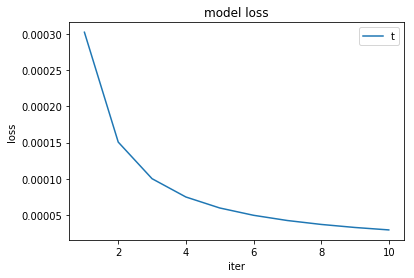

In [55]:
plt.plot(np.arange(1 , len(dnn.loss) + 1) , dnn.loss , label = "loss")
# plt.plot(np.arange(1 , len(slr.val_loss) + 1) , slr.val_loss , label = "test_loss")
plt.title("model loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.legend("train_loss")
plt.show()

In [56]:
dnn._predict(X_test)

array([9])

In [57]:
dnn.accuracy(X_test,y_test)

0.1009